# GCN

## Load the data

In [153]:
import os
from pathlib import Path
import pickle

PATH = '' # os.path.join(Path.cwd().parents[2], 'data/processed/graphs_labels')

with open(os.path.join(PATH, "graphs_with_labels.pkl"), "rb") as f:
    graphs, labels = pickle.load(f)

### sample

/tmp/ipython-input-154-3026701571.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


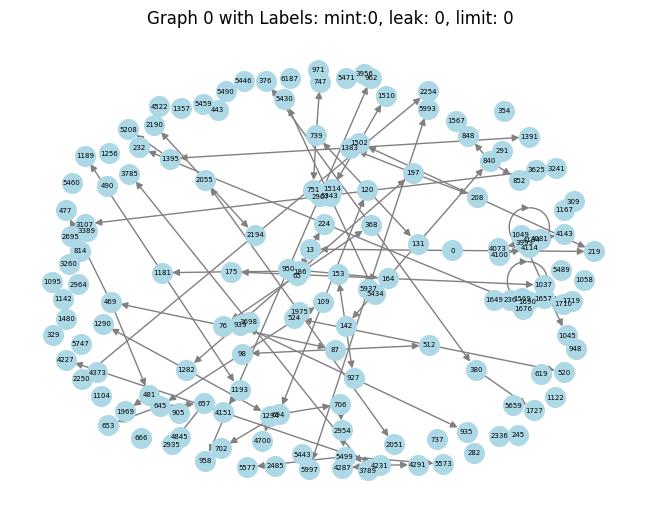

/tmp/ipython-input-154-3026701571.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


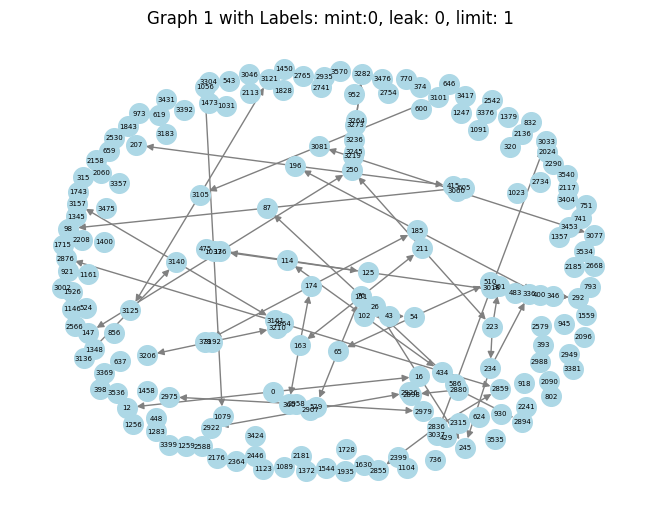

/tmp/ipython-input-154-3026701571.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


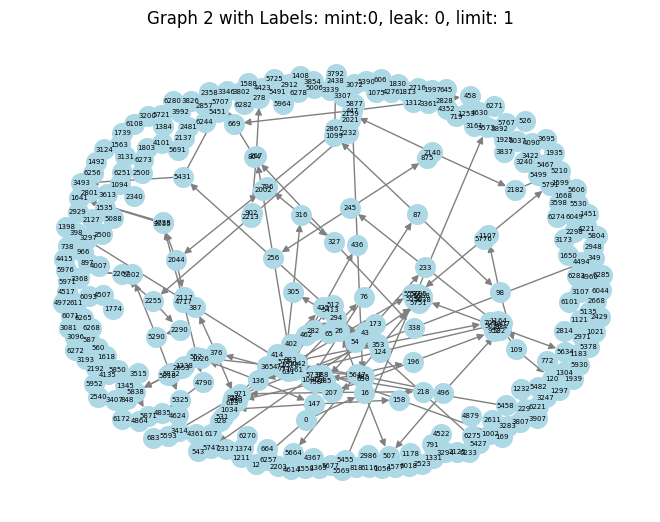

In [154]:
import networkx as nx
import matplotlib.pyplot as plt

for i, (graph, label) in enumerate(zip(graphs, labels)):
    nx.draw(graph, with_labels=True, node_color='lightblue', node_size=200, edge_color='gray', font_size=5)
    plt.title(f"Graph {i} with Labels: mint:{label['mint']}, leak: {label['mint']}, limit: {label['limit']}")
    plt.tight_layout()
    plt.show()
    if i == 2:
        break

## Install required packages.

In [155]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git


2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html


In [156]:
import torch
from torch_geometric.utils import from_networkx

dataset = []

for graph, label in zip(graphs, labels):
    data = from_networkx(graph)
    label_value = [l for l in label.values()]
    degrees = torch.tensor([d for _, d in graph.degree()], dtype=torch.float).unsqueeze(1)
    data.y = torch.tensor(label_value, dtype=torch.float).unsqueeze(0)
    data.x = degrees
    dataset.append(data)

In [157]:
from torch_geometric.data import DataLoader

# Data Loader
loader = DataLoader(dataset, batch_size=4, shuffle=True)

/tmp/ipython-input-157-1246845923.py:4: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [158]:
for batch in loader:
    print(batch)
    print(batch.x.shape, batch.y.shape)
    break

DataBatch(edge_index=[2, 790], num_nodes=1793, y=[4, 3], x=[1793, 1], batch=[1793], ptr=[5])
torch.Size([1793, 1]) torch.Size([4, 3])


In [159]:
import numpy as np
from sklearn.metrics import f1_score

def tune_thresholds(y_true, y_pred_prob, metric='f1'):
    y_true = np.asarray(y_true)          # Fix: convert to NumPy
    y_pred_prob = np.asarray(y_pred_prob)

    best_thresholds = []
    best_scores = []

    for i in range(y_true.shape[1]):
        label_true = y_true[:, i]
        label_probs = y_pred_prob[:, i]  # Fix here too

        thresholds = np.linspace(0.0, 1.0, 101)
        scores = []

        for t in thresholds:
            label_pred = (label_probs >= t).astype(int)
            if metric == 'f1':
                score = f1_score(label_true, label_pred, zero_division=0)
            scores.append(score)

        best_t = thresholds[np.argmax(scores)]
        best_score = np.max(scores)

        best_thresholds.append(best_t)
        best_scores.append(best_score)

        print(f"Label {i}: Best threshold = {best_t:.2f}, Best {metric} = {best_score:.4f}")

    return best_thresholds, best_scores


In [160]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Define the GNN Model
class MultiLabelGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_labels):
        super(MultiLabelGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_labels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = torch.sigmoid(self.lin(x))  # Multi-label sigmoid activation
        return x

# Split your dataset
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# Initialize Model, Loss, Optimizer
model = MultiLabelGCN(in_channels=1, hidden_channels=64, num_labels=3)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [161]:
# Training Loop
for epoch in range(1, 101):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.7009
Epoch 2, Loss: 0.6859
Epoch 3, Loss: 0.6709
Epoch 4, Loss: 0.6555
Epoch 5, Loss: 0.6405
Epoch 6, Loss: 0.6206
Epoch 7, Loss: 0.6015
Epoch 8, Loss: 0.5869
Epoch 9, Loss: 0.5776
Epoch 10, Loss: 0.5716
Epoch 11, Loss: 0.5670
Epoch 12, Loss: 0.5709
Epoch 13, Loss: 0.5728
Epoch 14, Loss: 0.5655
Epoch 15, Loss: 0.5685
Epoch 16, Loss: 0.5648
Epoch 17, Loss: 0.5651
Epoch 18, Loss: 0.5644
Epoch 19, Loss: 0.5631
Epoch 20, Loss: 0.5630
Epoch 21, Loss: 0.5614
Epoch 22, Loss: 0.5609
Epoch 23, Loss: 0.5654
Epoch 24, Loss: 0.5634
Epoch 25, Loss: 0.5600
Epoch 26, Loss: 0.5648
Epoch 27, Loss: 0.5637
Epoch 28, Loss: 0.5593
Epoch 29, Loss: 0.5600
Epoch 30, Loss: 0.5606
Epoch 31, Loss: 0.5583
Epoch 32, Loss: 0.5600
Epoch 33, Loss: 0.5587
Epoch 34, Loss: 0.5592
Epoch 35, Loss: 0.5594
Epoch 36, Loss: 0.5599
Epoch 37, Loss: 0.5563
Epoch 38, Loss: 0.5583
Epoch 39, Loss: 0.5576
Epoch 40, Loss: 0.5562
Epoch 41, Loss: 0.5568
Epoch 42, Loss: 0.5612
Epoch 43, Loss: 0.5571
Epoch 44, Loss: 0.55

In [162]:
# Evaluation Function
def evaluate(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index, batch.batch)
            best_thresholds, _ = tune_thresholds(batch.y.cpu(), out.cpu()) # Pass out.cpu() to tune_thresholds
            best_thresholds = torch.tensor(best_thresholds, device=out.device) # Convert best_thresholds to a tensor
            pred = (out > best_thresholds).float()
            y_pred.append(pred.cpu())
            y_true.append(batch.y.cpu())
    y_true = torch.vstack(y_true).numpy()
    y_pred = torch.vstack(y_pred).numpy()
    print(classification_report(y_true, y_pred, target_names=['mint', 'leak', 'limit']))

# Run Evaluation
evaluate(test_loader)

Label 0: Best threshold = 0.00, Best f1 = 0.6667
Label 1: Best threshold = 0.00, Best f1 = 0.2222
Label 2: Best threshold = 0.46, Best f1 = 0.6667
Label 0: Best threshold = 0.21, Best f1 = 0.5714
Label 1: Best threshold = 0.13, Best f1 = 0.4000
Label 2: Best threshold = 0.00, Best f1 = 0.6667
              precision    recall  f1-score   support

        mint       0.46      1.00      0.63         6
        leak       0.17      1.00      0.29         2
       limit       0.56      0.83      0.67         6

   micro avg       0.38      0.93      0.54        14
   macro avg       0.39      0.94      0.53        14
weighted avg       0.46      0.93      0.60        14
 samples avg       0.37      0.68      0.46        14



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
